In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import torch.nn.functional
import task1

In [142]:
# TODO: flip the order in target and context mapping
class Word2VecDataset(Dataset):
    def __init__(self, corpus):
        self.preprocessed_data = []
        self.corpus = corpus

    def __len__(self):
        return len(self.preprocessed_data)

    def __getitem__(self, index):
        target, context = self.preprocessed_data[index]
        context_tensor = torch.tensor(context, dtype=torch.long)

        total_padding = 2 * context_window-len(context_tensor)

        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        context = torch.nn.functional.pad(context_tensor, (left_padding, right_padding), value=0)
        return torch.tensor(target, dtype=torch.long), context

    def preprocess_data(self, word_index_mapping):
        data = []
        for key in self.corpus:
            tokens = self.corpus[key]

            n = len(tokens)

            for i in range(0, n):
                target = tokens[i]

                # if target not in word_index_mapping:
                #     print(f"Warning: '{target}' not found in vocabulary, skipping.")
                #     continue  # Skip this word

                tokens_before_word = tokens[max(0, i - context_window):i]
                tokens_after_word = tokens[i + 1: min( n + 1 , i + 1 + context_window)]

                context = tokens_before_word + tokens_after_word

                target_index = word_index_mapping[target]
                context_index = []
                for word in context :
                    if word in word_index_mapping:
                        context_index.append(word_index_mapping[word])

                if len(context_index) > 0:
                    data.append((target_index, context_index))

        self.preprocessed_data = data

In [143]:
class Word2VecModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Embedding(vocab_size, embedding_dim),
            nn.Linear(embedding_dim, vocab_size)
        )
    def forward(self, context):
        embedding = self.network[0](context)
        aggregated_embeddings = embedding.mean(dim=1)
        return self.network[1](aggregated_embeddings)

    def train(self, model, criterion, optimizer):
        # model.train() # enable this if we r able to implement some dropout thingy
        loss_list, val_loss = [], []

        for _ in tqdm(range(epochs)):
            total_loss = 0

            for target, context in train_dataloader:
                target = target.long()
                context = context.long()
                
                pred = model.forward(context)
                loss = criterion(pred, target)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            number_of_samples = len(train_dataloader)
            avg_loss = total_loss / number_of_samples
            loss_list.append(avg_loss)
            print(f"Epoch {_ + 1}, Loss: {avg_loss}")

            total_loss = 0

            with torch.no_grad():
                for target, context in val_dataloader:
                    target = target.long()
                    context = context.long()

                    pred = model.forward(context)
                    loss = criterion(pred, target)
                    total_loss += loss.item()

            avg_val_loss = total_loss / len(val_dataloader)
            val_loss.append(avg_val_loss)
        
        return loss_list, val_loss

    # def get_triplets(self, model):
    #     embeddings = model.network[0].weight.data.cpu().numpy()
    #     similarities = cosine_similarity(embeddings)
    #     triplets = []
    #
    #     for item in word_index_mapping:
    #         word, index = item[0], item[1]
    #
    #         similar, triplet = [], []
    #         similar_indices = np.argsort(similarities[index])[::-1]
    #         similar_indices = similar_indices[:3]
    #
    #         for i in similar_indices:
    #             similar.append(index_word_mapping[i])
    #         del similar[index_word_mapping[index]]
    #
    #         dissimilar_index = np.argsort(similarities[idx])[0]
    #         dissimilar = index_word_mapping[dissimilar_index]
    #
    #         triplet = [word, similar, dissimilar]
    #         triplets.append(triplet)
    #
    #     for triplet in triplets:
    #         print("Word:", triplet[0])
    #         print("Similar:", triplet[1])
    #         print("Dissimilar:", triplet[2])
    #         print()
    def get_triplets(self):
        embeddings = self.network[0].weight.data.cpu().numpy()
        similarities = cosine_similarity(embeddings)

        triplets = []

        for word, index in word_index_mapping.items():
            similar = []

            similar_indices = np.argsort(similarities[index])[::-1]

            similar_indices = [i for i in similar_indices if i != index][:3]

            for i in similar_indices:
                similar.append(index_word_mapping[i])

            dissimilar_index = np.argsort(similarities[index])[0]
            dissimilar = index_word_mapping[dissimilar_index]

            triplets.append([word, similar, dissimilar])

        for triplet in triplets:
            print("Word:", triplet[0])
            print("Similar:", triplet[1])
            print("Dissimilar:", triplet[2])
            print()

        return triplets

In [144]:
def get_data(vocab_size, split = 0.9):
    # task1.make_vocab_and_tokenize(vocab_size)

    file_path = "tokenized_data.json"
    with open(file_path, "r", encoding="utf-8") as file:
        corpus = json.load(file)

    vocab_file_path = "vocabulary_86.txt"

    with open(vocab_file_path, "r", encoding="utf-8") as f:
        vocab = [line.strip() for line in f]

    word_index_mapping = {word: idx for idx, word in enumerate(vocab)}
    index_word_mapping = {idx: word for word, idx in word_index_mapping.items()}
    dataset = Word2VecDataset(corpus)
    dataset.preprocess_data(word_index_mapping)

    n = len(dataset)
    train = int(n * split)
    val = n - train

    train_dataset, val_dataset = random_split(dataset, [train, val])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle= True)

    return train_dataloader, val_dataloader, word_index_mapping, index_word_mapping

def plot(loss_list, val_loss):
    plt.plot(range(1, epochs + 1), loss_list, label="Training Loss")
    plt.plot(range(1, epochs + 1), val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.savefig("task_2.png")
    plt.legend()
    plt.grid(visible=True)
    plt.show()


In [145]:
vocabulary_size = 5000
context_window = 2
embedding_dim = 150
batch_size = 128
epochs = 10
lr = 0.001

train_dataloader,val_dataloader, word_index_mapping, index_word_mapping = get_data(vocabulary_size)

KeyError: 'y'

In [135]:
model = Word2VecModel(vocabulary_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_list, val_loss = model.train(model ,criterion, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]


IndexError: index out of range in self

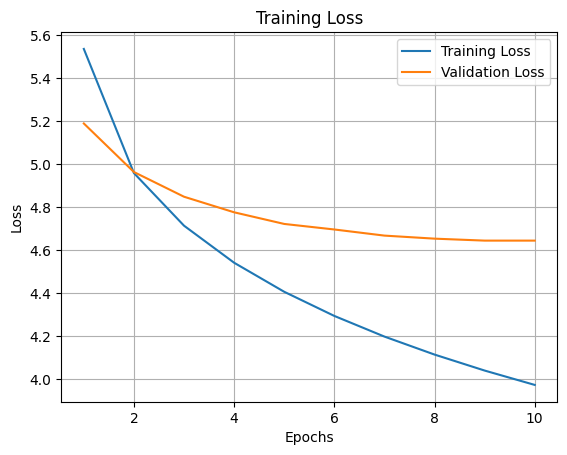

Word: i
Similar: ['car', 'recently', 'cool']
Dissimilar: depressed

Word: feel
Similar: ['reality', 'means', 'thought']
Dissimilar: shitty

Word: and
Similar: ['##isi', 'recently', 'knowing']
Dissimilar: called

Word: to
Similar: ['around', 'song', '##ve']
Dissimilar: went

Word: the
Similar: ['these', 'walking', 'instead']
Dissimilar: changes

Word: a
Similar: ['lame', 'side', 'college']
Dissimilar: hand

Word: that
Similar: ['inadequate', 'wasn', 'must']
Dissimilar: death

Word: feeling
Similar: ['remind', '##grate', 'looks']
Dissimilar: water

Word: of
Similar: ['water', 'faithful', 'page']
Dissimilar: realize

Word: my
Similar: ['son', 'your', 'their']
Dissimilar: sick

Word: in
Similar: ['feet', 'house', 'race']
Dissimilar: been

Word: it
Similar: ['writing', 'long', 'while']
Dissimilar: personal

Word: like
Similar: ['positive', 'wearing', 'eye']
Dissimilar: everyone

Word: im
Similar: ['romantic', 'remember', 'easy']
Dissimilar: weekend

Word: for
Similar: ['since', 'haven', 'li

[['i', ['car', 'recently', 'cool'], 'depressed'],
 ['feel', ['reality', 'means', 'thought'], 'shitty'],
 ['and', ['##isi', 'recently', 'knowing'], 'called'],
 ['to', ['around', 'song', '##ve'], 'went'],
 ['the', ['these', 'walking', 'instead'], 'changes'],
 ['a', ['lame', 'side', 'college'], 'hand'],
 ['that', ['inadequate', 'wasn', 'must'], 'death'],
 ['feeling', ['remind', '##grate', 'looks'], 'water'],
 ['of', ['water', 'faithful', 'page'], 'realize'],
 ['my', ['son', 'your', 'their'], 'sick'],
 ['in', ['feet', 'house', 'race'], 'been'],
 ['it', ['writing', 'long', 'while'], 'personal'],
 ['like', ['positive', 'wearing', 'eye'], 'everyone'],
 ['im', ['romantic', 'remember', 'easy'], 'weekend'],
 ['for', ['since', 'haven', 'living'], 'really'],
 ['me', ['cannot', 'learn', 'tender'], 'incredibly'],
 ['so', ['wouldn', 'upset', 'cause'], 'new'],
 ['but', ['knew', 'perfect', 'strongly'], 'kid'],
 ['was', ['##py', 'audience', 'kind'], 'issue'],
 ['is', ['dull', 'distressed', 'aren'], 'mis

In [119]:
plot(loss_list, val_loss)

torch.save(model.state_dict(), "word2vec_checkpoint.pth")

model.get_triplets()

In [123]:
def get_triplet_for_word(self, word):
    if word not in word_index_mapping:
        print(f"Word '{word}' not found in vocabulary.")
        return None

    index = word_index_mapping[word]
    embeddings = self.network[0].weight.data.cpu().numpy()
    similarities = cosine_similarity(embeddings)

    # Get sorted indices of words based on similarity (descending order)
    similar_indices = np.argsort(similarities[index])[::-1]

    # Exclude the word itself (index = `index`)
    similar_indices = [i for i in similar_indices if i != index][:3]

    similar_words = [(index_word_mapping[i], similarities[index][i]) for i in similar_indices]

    # Find the most dissimilar word (smallest similarity score)
    dissimilar_index = np.argsort(similarities[index])[0]  # Least similar word
    dissimilar_word = index_word_mapping[dissimilar_index]
    dissimilar_similarity = similarities[index][dissimilar_index]

    # Print results
    print(f"Word: {word}")
    print("Similar Words (with Cosine Similarity):")
    for sim_word, sim_value in similar_words:
        print(f"  {sim_word}: {sim_value:.4f}")

    print(f"Dissimilar Word: {dissimilar_word} (Cosine Similarity: {dissimilar_similarity:.4f})\n")

    return word, similar_words, (dissimilar_word, dissimilar_similarity)

get_triplet_for_word(model,"is")

Word: is
Similar Words (with Cosine Similarity):
  dull: 0.3077
  distressed: 0.2678
  aren: 0.2407
Dissimilar Word: miserable (Cosine Similarity: -0.2654)



('is',
 [('dull', np.float32(0.3077452)),
  ('distressed', np.float32(0.26777777)),
  ('aren', np.float32(0.24071905))],
 ('miserable', np.float32(-0.2654241)))